In [3]:
# Instalação das bibliotecas
# NLTK (Natural Language Toolkit) --> análise linguística.
# VADER --> análise de sentimentos otimizada para textos de mídias sociais.
import sys
!pip install nltk vaderSentiment tqdm
!pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [4]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from tqdm.auto import tqdm

# NLTK
from nltk.corpus import stopwords

# SpaCy para português
import spacy

# VADER
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Sklearn
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Configurações visuais
sns.set_style('whitegrid')
%matplotlib inline

# Download NLTK necessário
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('vader_lexicon', quiet=True)

# Download SpaCy pt_core_news_sm se não tiver (rodar no terminal):
# !python -m spacy download pt_core_news_sm

# Carregar modelo SpaCy português
nlp = spacy.load('pt_core_news_sm')

# Inicializa tqdm para pandas
tqdm.pandas()


ImportError: DLL load failed while importing _path: Não foi possível encontrar o módulo especificado.

In [ ]:
# Carregar os dados rotulados e principais (ajuste os caminhos se necessário)
df_main = pd.read_csv('dados_combinados.csv')
df1 = pd.read_csv('amostra_1_rotulada.csv', header=0)
df2 = pd.read_csv('amostra_2_rotulada.csv', header=0)
df3 = pd.read_csv('amostra_3_rotulada.csv', header=0)
df4 = pd.read_csv('amostra_4_rotulada.csv', header=0)
df5 = pd.read_csv('amostra_5_rotulada.csv', header=0)

# Concatenar os dados rotulados humanos
df_rotulado = pd.concat([df1, df2, df3, df4, df5], ignore_index=True)

# Limpeza básica
df_main.dropna(subset=['title', 'label'], inplace=True)

# Reduzir para 10% para prototipagem (ajuste se quiser)
fracao_para_prototipar = 0.1
df_main = df_main.sample(frac=fracao_para_prototipar, random_state=42)

# Mapear labels para numérico
df_main['label_numeric'] = df_main['label'].map({'true': 0, 'fake': 1})

print("Dataset principal:")
display(df_main.head())

print("\nDataset rotulado:")
display(df_rotulado.head())


In [ ]:
analyzer = SentimentIntensityAnalyzer()

# Função para extrair sentimento pos, neu, neg
def get_vader_scores_all(text):
    scores = analyzer.polarity_scores(text)
    return scores['pos'], scores['neu'], scores['neg']

print("Extraindo features numéricas e sentimento para df_main...")
df_main['exclamation_count'] = df_main['title'].str.count('!')
df_main['question_mark_count'] = df_main['title'].str.count('\?')
df_main['word_count'] = df_main['title_cleaned'].progress_apply(lambda x: len(x.split()))
df_main['char_count'] = df_main['title_cleaned'].progress_apply(len)
df_main[['sentiment_pos', 'sentiment_neu', 'sentiment_neg']] = df_main['title_cleaned'].progress_apply(lambda x: pd.Series(get_vader_scores_all(x)))

print("Extraindo features numéricas e sentimento para df_rotulado...")
df_rotulado['exclamation_count'] = df_rotulado['title'].str.count('!')
df_rotulado['question_mark_count'] = df_rotulado['title'].str.count('\?')
df_rotulado['word_count'] = df_rotulado['title_cleaned'].progress_apply(lambda x: len(x.split()))
df_rotulado['char_count'] = df_rotulado['title_cleaned'].progress_apply(len)
df_rotulado[['sentiment_pos', 'sentiment_neu', 'sentiment_neg']] = df_rotulado['title_cleaned'].progress_apply(lambda x: pd.Series(get_vader_scores_all(x)))


In [ ]:
# Seletores para pipeline

class TextSelector(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X['title_cleaned']

class NumberSelector(BaseEstimator, TransformerMixin):
    def __init__(self, cols):
        self.cols = cols
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.cols]


In [ ]:
# Definir quais features numéricas usar
num_features = ['exclamation_count', 'question_mark_count', 'word_count', 'char_count', 'sentiment_pos', 'sentiment_neu', 'sentiment_neg']

from sklearn.pipeline import FeatureUnion

combined_features = FeatureUnion([
    ('text', Pipeline([
        ('selector', TextSelector()),
        ('tfidf', TfidfVectorizer(ngram_range=(1,2), max_features=3000)),
    ])),
    ('numeric', Pipeline([
        ('selector', NumberSelector(num_features)),
    ])),
])

pipeline = Pipeline([
    ('features', combined_features),
    ('classifier', RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42))
])

# Preparar dados
X = df_main[['title_cleaned'] + num_features]
y = df_main['label_numeric']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Treinamento
pipeline.fit(X_train, y_train)

# Avaliação
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))


In [ ]:
# Como RandomForest não dá importância para TF-IDF direto, vamos só para os numéricos

importances = pipeline.named_steps['classifier'].feature_importances_

# Como TF-IDF tem milhares de features, somamos só as numéricas que vêm depois dos TF-IDF
tfidf_n_features = pipeline.named_steps['features'].transformer_list[0][1].named_steps['tfidf'].vocabulary_
num_features_importances = importances[-len(num_features):]

feat_imp_df = pd.DataFrame({
    'feature': num_features,
    'importance': num_features_importances
}).sort_values(by='importance', ascending=False)

print("Importância dos atributos numéricos:")
print(feat_imp_df)

# Gráfico
plt.figure(figsize=(8,5))
sns.barplot(x='importance', y='feature', data=feat_imp_df)
plt.title("Importância dos Atributos Numéricos no Modelo")
plt.show()


In [3]:
# Carregamento dos dados

# Baixar o arquivo principal usando wget
# !wget -O dados_combinados.csv "https://raw.githubusercontent.com/Gabrielzzz7/news-appeal-analysis/refs/heads/main/dados_combinados.csv?token=GHSAT0AAAAAADEW5VP7Y5S4IROVX5LB2JUG2DKS5RQ"

df_main = pd.read_csv('dados_combinados.csv')
df1 = pd.read_csv('amostra_1_rotulada.csv', header=0)
df2 = pd.read_csv('amostra_2_rotulada.csv', header=0)
df3 = pd.read_csv('amostra_3_rotulada.csv', header=0)
df4 = pd.read_csv('amostra_4_rotulada.csv', header=0)
df4 = pd.read_csv('amostra_5_rotulada.csv', header=0)
df_rotulado = pd.concat([df1, df2, df3, df4], ignore_index=True)


# Preparação do df_main
df_main.dropna(subset=['title', 'label'], inplace=True)

# Para rodar com o dataset completo
fracao_para_prototipar = 0.1 # Use 10% do dataset
df_main = df_main.sample(frac=fracao_para_prototipar, random_state=42)

df_main.loc[:, 'label_numeric'] = df_main['label'].map({'true': 0, 'fake': 1})

print("\n--- Visão geral do Dataset Principal (lido localmente) ---")
print(df_main.head())

print("\n\n--- Visão geral do Dataset com Rótulos Humanos ---")
print(df_rotulado.head())


--- Visão geral do Dataset Principal (lido localmente) ---
                         id  \
4291   gossipcop-8734494756   
14922      gossipcop-842955   
19868      gossipcop-844164   
12669      gossipcop-920887   
12570      gossipcop-926989   

                                                news_url  \
4291   www.usmagazine.com/celebrity-news/news/will-bi...   
14922  https://www.usmagazine.com/celebrity-news/news...   
19868  https://www.upi.com/Entertainment_News/Movies/...   
12669  https://www.hollywoodreporter.com/live-feed/x-...   
12570  https://www.usatoday.com/story/life/tv/2018/12...   

                                                   title  \
4291   Will Bindi Irwin Get Married to Boyfriend Chan...   
14922  Bob Harper: Howard Stern Reached Out to Me Aft...   
19868  'Guardians of the Galaxy Vol. 2' cast play Gue...   
12669  'The X-Files': What Did Scully Whisper to Mulder?   
12570  'Today': Ratings show replacing Matt Lauer wit...   

                               

In [4]:
# Pré-processamento e Limpeza dos Textos

stop_words = set(stopwords.words('portuguese'))

def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)

print("Limpando textos do dataset principal:")
df_main['title_cleaned'] = df_main['title'].progress_apply(preprocess_text)

print("\nLimpando textos do dataset humano:")
df_rotulado['title_cleaned'] = df_rotulado['title'].progress_apply(preprocess_text)

print("\nPré-processamento concluído para ambos os datasets.")

Limpando textos do dataset principal:


100%|██████████| 2320/2320 [00:01<00:00, 1692.04it/s]



Limpando textos do dataset humano:


100%|██████████| 876/876 [00:00<00:00, 5544.31it/s]


Pré-processamento concluído para ambos os datasets.


In [5]:
# Extração de Atributos

def count_pos_tags(text):
    tokens = word_tokenize(text, language='portuguese')
    tags = pos_tag(tokens)
    adjectives = len([word for word, tag in tags if tag.startswith('JJ')])
    adverbs = len([word for word, tag in tags if tag.startswith('RB')])
    return adjectives, adverbs

def get_vader_scores(text):
    analyzer = SentimentIntensityAnalyzer()
    scores = analyzer.polarity_scores(text)
    return scores['compound']

def extract_features(df):
    print("Extraindo contagem de pontuação...")
    df['exclamation_count'] = df['title'].str.count('!')
    df['question_mark_count'] = df['title'].str.count('\?')

    print("Contando tags morfossintáticas (adjetivos, advérbios)...")
    df[['adjectives', 'adverbs']] = df['title_cleaned'].progress_apply(lambda x: pd.Series(count_pos_tags(x)))

    print("Contando palavras e caracteres...")
    df['word_count'] = df['title_cleaned'].progress_apply(lambda x: len(x.split()))
    df['char_count'] = df['title_cleaned'].progress_apply(len)

    print("Analisando sentimento...")
    df['sentiment_compound'] = df['title_cleaned'].progress_apply(get_vader_scores)
    return df

# Aplicar a nova função de extração em ambos os DataFrames
print("--- Processando df_main ---")
df_main = extract_features(df_main)
print("\n--- Processando df_rotulado ---")
df_rotulado = extract_features(df_rotulado)

print("\nExtração de atributos concluída.")
# Mostrando os novos atributos no dataset humano como exemplo
print(df_rotulado[['title', 'exclamation_count', 'question_mark_count']].head())

--- Processando df_main ---

<>:18: SyntaxWarning: invalid escape sequence '\?'
<>:18: SyntaxWarning: invalid escape sequence '\?'
C:\Users\gabri\AppData\Local\Temp\ipykernel_28064\2504977915.py:18: SyntaxWarning: invalid escape sequence '\?'
  df['question_mark_count'] = df['title'].str.count('\?')



Extraindo contagem de pontuação...
Contando tags morfossintáticas (adjetivos, advérbios)...


100%|██████████| 2320/2320 [00:05<00:00, 423.90it/s]


Contando palavras e caracteres...


100%|██████████| 2320/2320 [00:00<00:00, 348773.67it/s]


Analisando sentimento...


100%|██████████| 2320/2320 [00:25<00:00, 90.71it/s] 



--- Processando df_rotulado ---
Extraindo contagem de pontuação...
Contando tags morfossintáticas (adjetivos, advérbios)...


100%|██████████| 876/876 [00:00<00:00, 3151.92it/s]


Contando palavras e caracteres...


100%|██████████| 876/876 [00:00<00:00, 881739.93it/s]


Analisando sentimento...


100%|██████████| 876/876 [00:08<00:00, 103.53it/s]


Extração de atributos concluída.
                                               title  exclamation_count  \
0  Will Bindi Irwin Get Married to Boyfriend Chan...                0.0   
1  Bob Harper: Howard Stern Reached Out to Me Aft...                0.0   
2  'Guardians of the Galaxy Vol. 2' cast play Gue...                1.0   
3  'The X-Files': What Did Scully Whisper to Mulder?                0.0   
4  'Today': Ratings show replacing Matt Lauer wit...                0.0   

   question_mark_count  
0                  1.0  
1                  0.0  
2                  0.0  
3                  1.0  
4                  0.0  


--- Parte 1: Análise e Modelo para Fake vs. Verdadeira ---


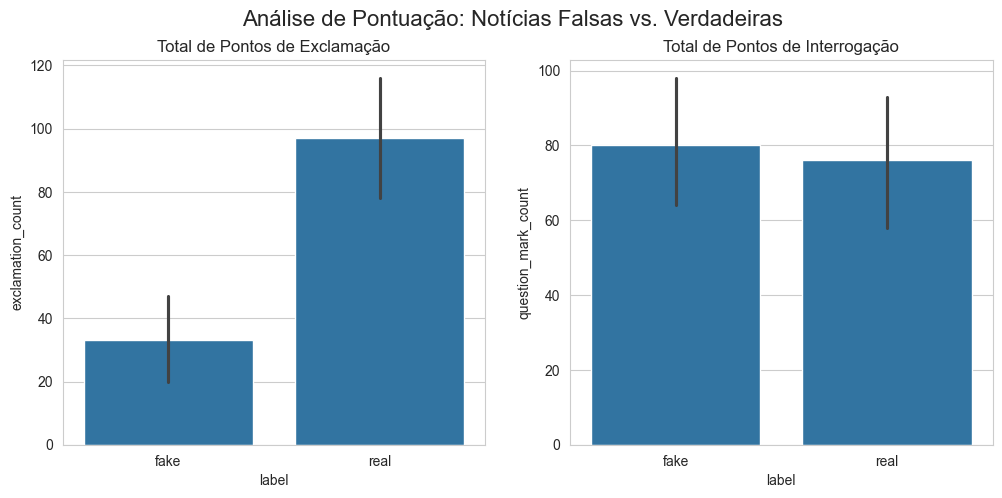


Importância dos Atributos para Diferenciar Fake News (com pontuação):
               feature  importance
0           word_count         0.0
1           char_count         0.0
2           adjectives         0.0
3              adverbs         0.0
4   sentiment_compound         0.0
5    exclamation_count         0.0
6  question_mark_count         0.0


In [6]:
# Análise e Modelo para Fake vs. Verdadeira

print("--- Parte 1: Análise e Modelo para Fake vs. Verdadeira ---")

# Adicionar os novos atributos à lista de features
features = ['word_count', 'char_count', 'adjectives', 'adverbs', 'sentiment_compound', 'exclamation_count', 'question_mark_count']

# Gráficos
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Análise de Pontuação: Notícias Falsas vs. Verdadeiras', fontsize=16)
sns.barplot(ax=axes[0], x='label', y='exclamation_count', data=df_main, estimator=sum)
axes[0].set_title('Total de Pontos de Exclamação')
sns.barplot(ax=axes[1], x='label', y='question_mark_count', data=df_main, estimator=sum)
axes[1].set_title('Total de Pontos de Interrogação')
plt.show()


# Modelo Auxiliar
X = df_main[features]
y = df_main['label_numeric']
X = X[y.notna()]
y = y[y.notna()]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)

# Importância dos Atributos
feature_importances = pd.DataFrame({'feature': features, 'importance': rf_model.feature_importances_}).sort_values('importance', ascending=False)
print("\nImportância dos Atributos para Diferenciar Fake News (com pontuação):")
print(feature_importances)



--- Parte 2: Análise da Rotulação Humana de 'Apelo' ---


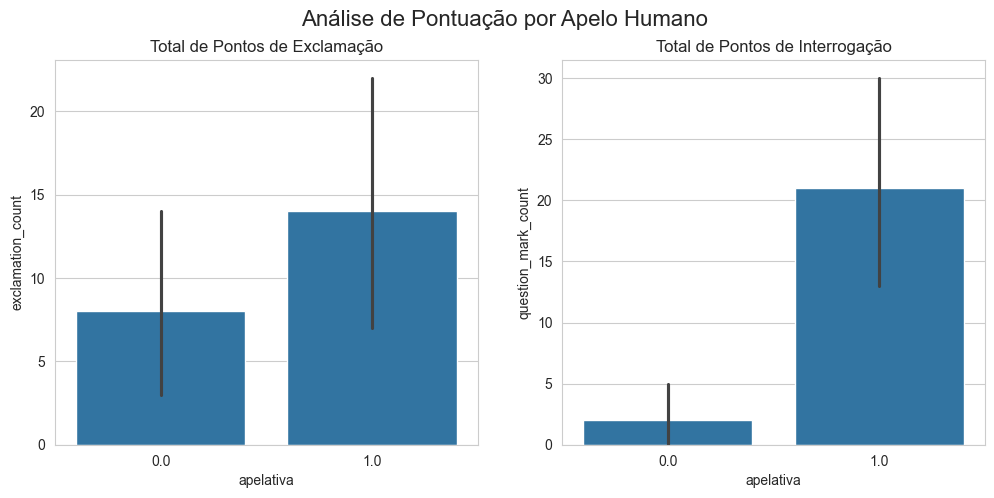


Importância dos Atributos para Identificar um Título Apelativo (com pontuação):
               feature  importance
1           char_count    0.328383
4   sentiment_compound    0.251848
0           word_count    0.197158
2           adjectives    0.099262
3              adverbs    0.049443
6  question_mark_count    0.045818
5    exclamation_count    0.028090


In [7]:
# Análise e Modelo para Apelativa vs. Não Apelativa

print("\n\n--- Parte 2: Análise da Rotulação Humana de 'Apelo' ---")

# Adicionar os novos atributos à lista de features
features_apelativa = ['word_count', 'char_count', 'adjectives', 'adverbs', 'sentiment_compound', 'exclamation_count', 'question_mark_count']

# Gráficos
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Análise de Pontuação por Apelo Humano', fontsize=16)
sns.barplot(ax=axes[0], x='apelativa', y='exclamation_count', data=df_rotulado, estimator=sum)
axes[0].set_title('Total de Pontos de Exclamação')
sns.barplot(ax=axes[1], x='apelativa', y='question_mark_count', data=df_rotulado, estimator=sum)
axes[1].set_title('Total de Pontos de Interrogação')
plt.show()

# Modelo para Prever o Apelo
X_apelativa = df_rotulado[features_apelativa]
y_apelativa = df_rotulado['apelativa']
X_apelativa = X_apelativa[y_apelativa.notna()]
y_apelativa = y_apelativa[y_apelativa.notna()]
X_train_ap, X_test_ap, y_train_ap, y_test_ap = train_test_split(X_apelativa, y_apelativa, test_size=0.3, random_state=42, stratify=y_apelativa)
rf_apelativa_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_apelativa_model.fit(X_train_ap, y_train_ap)

# Importância dos Atributos para Apelo
feature_importances_apelativa = pd.DataFrame({'feature': features_apelativa, 'importance': rf_apelativa_model.feature_importances_}).sort_values('importance', ascending=False)
print("\nImportância dos Atributos para Identificar um Título Apelativo (com pontuação):")
print(feature_importances_apelativa)

In [8]:
# Classificação em Massa

print("--- Parte 3: Classificação em Massa do Dataset Principal ---")

# Utilizando os dados rotulados para treinar
features_apelativa = ['word_count', 'char_count', 'adjectives', 'adverbs', 'sentiment_compound', 'exclamation_count', 'question_mark_count']
X_total_humanos = df_rotulado[features_apelativa]
y_total_humanos = df_rotulado['apelativa']

# Garantir que não há valores nulos
X_total_humanos = X_total_humanos[y_total_humanos.notna()]
y_total_humanos = y_total_humanos[y_total_humanos.notna()]

# Criamos e treinamos o modelo final com todos os dados rotulados.
modelo_final_apelativa = RandomForestClassifier(n_estimators=100, random_state=42)
modelo_final_apelativa.fit(X_total_humanos, y_total_humanos)

print("Modelo final treinado com todos os dados humanos.")

# Garantir que o df_main tenha as mesmas features.
X_main_para_prever = df_main[features_apelativa]

# Usar o modelo treinado para prever os rótulos no dataset principal.
df_main['apelativa_predita'] = modelo_final_apelativa.predict(X_main_para_prever)

print(f"Classificação concluída! {sum(df_main['apelativa_predita'])} notícias foram classificadas como apelativas.")
print(df_main[['title', 'label', 'apelativa_predita']].head())

--- Parte 3: Classificação em Massa do Dataset Principal ---
Modelo final treinado com todos os dados humanos.
Classificação concluída! 972.0 notícias foram classificadas como apelativas.
                                                   title label  \
4291   Will Bindi Irwin Get Married to Boyfriend Chan...  fake   
14922  Bob Harper: Howard Stern Reached Out to Me Aft...  real   
19868  'Guardians of the Galaxy Vol. 2' cast play Gue...  real   
12669  'The X-Files': What Did Scully Whisper to Mulder?  real   
12570  'Today': Ratings show replacing Matt Lauer wit...  real   

       apelativa_predita  
4291                 1.0  
14922                0.0  
19868                0.0  
12669                1.0  
12570                0.0  



--- Parte 4: Análise Final em Larga Escala ---

Análise Cruzada: Fake/True vs. Apelativa/Não Apelativa
apelativa_predita   0.0  1.0
label                       
fake                284  286
real               1064  686


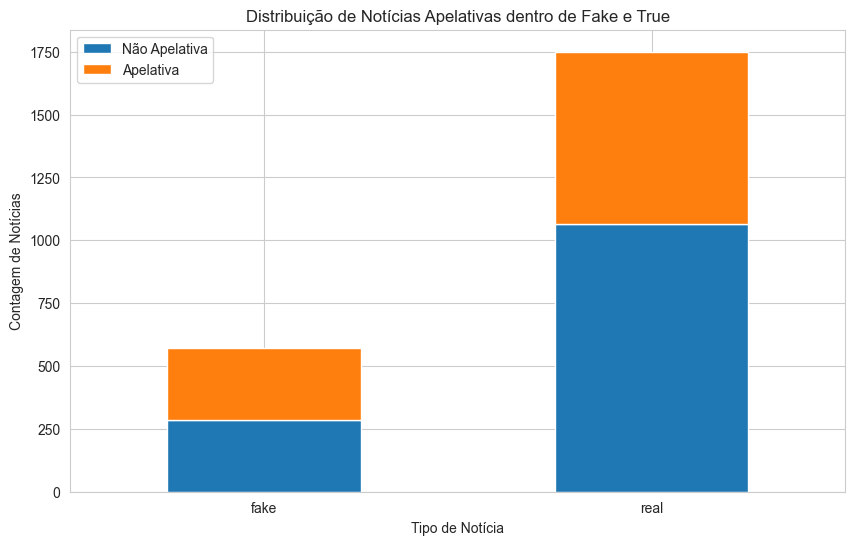


Análise Percentual:
apelativa_predita    0.0    1.0
label                          
fake               49.82  50.18
real               60.80  39.20


In [9]:
# Análise Final

print("\n--- Parte 4: Análise Final em Larga Escala ---")

# Cruzando as informações de Fake News com Apelo
analise_cruzada = pd.crosstab(df_main['label'], df_main['apelativa_predita'])
print("\nAnálise Cruzada: Fake/True vs. Apelativa/Não Apelativa")
print(analise_cruzada)

# Visualizando a proporção
analise_cruzada.plot(kind='bar', stacked=True, figsize=(10, 6), rot=0)
plt.title('Distribuição de Notícias Apelativas dentro de Fake e True')
plt.xlabel('Tipo de Notícia')
plt.ylabel('Contagem de Notícias')
plt.legend(['Não Apelativa', 'Apelativa'])
plt.show()

# Calculando a porcentagem
porcentagem = analise_cruzada.div(analise_cruzada.sum(axis=1), axis=0) * 100
print("\nAnálise Percentual:")
print(porcentagem.round(2))

In [10]:
# Teste de Significância Estatística (Qui-Quadrado)

from scipy.stats import chi2_contingency

print("--- Teste Qui-Quadrado de Independência ---")

# A função chi2_contingency precisa da tabela de contagem de frequência (não de porcentagem).
# Felizmente, já criamos essa tabela na célula anterior e a chamamos de 'analise_cruzada'.
print("Tabela de Contingência (Contagens):")
print(analise_cruzada)

# Realizar o teste
chi2, p_valor, dof, expected = chi2_contingency(analise_cruzada)

print(f"\nEstatística Qui-Quadrado: {chi2:.4f}")
print(f"P-valor do teste: {p_valor:.4f}")

# Interpretar o p-valor
alpha = 0.05
print(f"\nNível de significância (alpha): {alpha}")

--- Teste Qui-Quadrado de Independência ---
Tabela de Contingência (Contagens):
apelativa_predita   0.0  1.0
label                       
fake                284  286
real               1064  686

Estatística Qui-Quadrado: 20.8275
P-valor do teste: 0.0000

Nível de significância (alpha): 0.05
